In [2]:
from sklearn.decomposition import PCA
import data_prep as dp
import matplotlib.pyplot as plt
import statistics
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LinearRegression
import datetime as dt
import statsmodels.api as sm
import numpy as np
import pandas as pd
import scipy
import pickle


def itr(ac):
    itr = (np.log2(6)+ ac*np.log2(ac)+ (1-ac)* np.log2((1-ac)/(6-1)))*10
    return itr



pd.set_option('display.max_columns', 1500) 
pd.set_option('display.max_rows', 1500) 

In [2]:
!pip install openpyxl

In [3]:
def boxplot_accuracy(data,name:str):
    means = data.loc[(data.Ep2Avg==8)].groupby("Classifier").mean()["Accuracy"].to_list()
    names = data.loc[(data.Ep2Avg==8)].groupby("Classifier").mean().index.to_list()
    sorted_classifiers = np.array(sorted( zip(means, names)))
    df_list = []
    for classifier in sorted_classifiers[:,1]:
        df = data.loc[(data.Classifier == classifier)& (data.Ep2Avg == 8)]
        df_list.append(df.Accuracy*100)
    fig,ax = plt.subplots(figsize=(8.5,5))
    ax.boxplot(df_list,labels= sorted_classifiers[:,1],widths=0.3)
    ax.set_xticklabels(sorted_classifiers[:,1],rotation=30,ha='right')
    ax.set_ylabel("Accuracy (%)")
    ax.set_ylim(-5,100)
    fig.suptitle("Accuracy " +name)
    plt.savefig(r"C:\Users\map92fg\Documents\Software\P300_Classification\created_data\Graphics\Accuracies\Acc_"+name+".svg",format='svg',bbox_inches="tight",pad_inches=0.2)

def bar_itr(data,name:str):
    fig,ax = plt.subplots(figsize=(16,5))

    means = data.loc[(data.Ep2Avg==8)].groupby("Classifier").mean()["ITR"].to_list()
    names = data.loc[(data.Ep2Avg==8)].groupby("Classifier").mean().index.to_list()
    sorted_classifiers = np.array(sorted( zip(means, names)))
    values = [float(i) for i in sorted_classifiers[:,0]]
    df_list = []

    ax.bar(sorted_classifiers[:,1],values,width =0.25)
    ax.set_xticklabels(sorted_classifiers[:,1],rotation=30,ha='right')
    ax.set_ylabel("ITR (Bits/Minuite)")
    fig.suptitle("ITR " + name)
    plt.savefig(r"D:\Google Drive\Master\Masterarbeit\Graphics\ITR_boxplot_"+name+".png",bbox_inches="tight",pad_inches=0.2)
    
def plot_timeline(tar_df, ntar_df,electrode,title):
    col_list= ["#d8b365","#5ab4ac","#ef8a62","#67a9cf"]
    lr = LinearRegression()

    x = tar_df.index.map(dt.datetime.toordinal).to_numpy()
    x = x.reshape(-1,1)

    fig, ax = plt.subplots(figsize = (12,5))
    y = tar_df["Mean Amplitude"].to_numpy()-ntar_df["Mean Amplitude"].to_numpy()
    y.reshape(-1,1)
    lr.fit(x,y)
    pred = lr.predict(x)
    ax.axvline(x=tar_df.index.values[12],lw=1,alpha=1,zorder=0,c=col_list[2])
    ax.axvline(x=tar_df.index.values[21],lw=1,alpha=1,zorder=0,c=col_list[3])
    tar = ax.bar(tar_df.index,tar_df["Mean Amplitude"], width=1,color=col_list[1])
    ntar = ax.bar(tar_df.index,ntar_df["Mean Amplitude"], width=1,color=col_list[0])
    trend = ax.plot(tar_df.index,pred,c="k",ls=":",lw=0.85)
    lgd =ax.legend(["SetB","Tactilo Relacement","Difference Trend", "Target", "NonTarget"], ncol=5, title=title,loc='center', bbox_to_anchor=(0.5, 1.13),fontsize='small', fancybox=True)
    #ax.set_title(electrode)
    ax.axhline(y=0,c='k',lw=0.5)
    ax.set_ylabel("µV")

    ax.set_xlabel("Session Date")
    #fig.suptitle(title)
    fig.tight_layout
    plt.savefig(r"D:\Google Drive\Master\Masterarbeit\Graphics\Timeline.png",bbox_inches="tight",pad_inches=0.2)

# Amplitudes

In [15]:
def load_session_dates():
    with open(r"C:\Users\map92fg\Documents\Software\P300_Classification\data_thesis\date_dict.pickle", "rb") as file:
        SESS_DATES = pickle.load(file)
    return SESS_DATES

SESS_DATES = load_session_dates()
amp = pd.read_csv(r"C:\Users\map92fg\Documents\Software\P300_Classification\created_data\average_amplitudes_350_600.csv")
amp["Dates"] = amp["Session"].replace(SESS_DATES)

amp.to_csv(r"C:\Users\map92fg\Documents\Software\P300_Classification\created_data\average_amplitudes_350_600_with_dates.csv",index=False)


# Load Data

relabel data: single calibration data was split into two sets of electrodes

In [5]:
all_acc =  pd.read_csv(r"C:\Users\map92fg\Documents\Software\P300_Classification\created_data\Classifier_Results\accuracies_19_05_22_V2.csv")
all_acc["Condition"] = all_acc["Condition"].map({"sess3":"sess3","sess1":"sess1","single3_A":"single3","single3_B":"single3","single1_A":"single1","single1_B":"single1"}, na_action='ignore')
all_acc.to_csv(r"C:\Users\map92fg\Documents\Software\P300_Classification\created_data\Classifier_Results\accuracies.csv",index=False)
all_acc["Condition"].isnull().any().sum()

0

In [6]:
#change NaN values very SWLDA 
all_acc.Accuracy = all_acc.Accuracy.fillna(value=0)
all_acc.loc[all_acc.isnull().any(axis=1)]

,Accuracy,Classifier,Session,Condition,Ep2Avg


In [8]:
eight_epochs = all_acc.loc[all_acc.Ep2Avg==8]

sess3 = eight_epochs.loc[eight_epochs.Condition=="sess3"]
sess1 = eight_epochs.loc[eight_epochs.Condition=="sess1"]
single3 = eight_epochs.loc[eight_epochs.Condition=="single3"]
single1 = eight_epochs.loc[eight_epochs.Condition=="single1"]


In [9]:
sess1.loc[sess1.Accuracy == 0]

,Accuracy,Classifier,Session,Condition,Ep2Avg
6215,0.0,SWLDA,13,sess1,8
6255,0.0,SWLDA,14,sess1,8
6335,0.0,SWLDA,17,sess1,8
7119,0.0,MDM,40,sess1,8
7127,0.0,FGMDM,40,sess1,8


In [10]:
sess3.groupby("Classifier").count()

,Accuracy,Session,Condition,Ep2Avg
Classifier,,,,
FGMDM,39,39,39,39
FGMDM_res,39,39,39,39
FGMDM_res_xDawn,39,39,39,39
FGMDM_xDawn,39,39,39,39
LDA,39,39,39,39
LDA_xDawn,39,39,39,39
MDM,39,39,39,39
MDM_res,39,39,39,39
MDM_res_xDawn,39,39,39,39


In [11]:
sess3.groupby("Classifier").mean().sort_values("Accuracy")

,Accuracy,Session,Ep2Avg
Classifier,,,
MDM_res,0.326211,27.589744,8.0
MDM,0.481481,27.589744,8.0
FGMDM,0.555556,27.589744,8.0
MDM_res_xDawn,0.556980,27.589744,8.0
SWLDA,0.585470,27.589744,8.0
LDA,0.599715,27.589744,8.0
FGMDM_res,0.618234,27.589744,8.0
MDM_xDawn,0.642450,27.589744,8.0
LDA_xDawn,0.653846,27.589744,8.0


In [12]:
sess1.groupby("Classifier").mean().sort_values("Accuracy")

,Accuracy,Session,Ep2Avg
Classifier,,,
MDM_res,0.329060,27.589744,8.0
LDA,0.334758,27.589744,8.0
FGMDM,0.381766,27.589744,8.0
MDM,0.441595,27.589744,8.0
SWLDA,0.441595,27.589744,8.0
FGMDM_res,0.443020,27.589744,8.0
shrinkLDA,0.497151,27.589744,8.0
LDA_xDawn,0.507123,27.589744,8.0
MDM_res_xDawn,0.521368,27.589744,8.0


In [13]:
single3.groupby("Classifier").mean().sort_values("Accuracy")

,Accuracy,Session,Ep2Avg
Classifier,,,
MDM_res,0.163818,27.589744,8.0
MDM,0.168091,27.589744,8.0
FGMDM_res,0.289174,27.589744,8.0
LDA,0.316239,27.589744,8.0
FGMDM,0.326211,27.589744,8.0
shrinkLDA,0.344729,27.589744,8.0
LDA_xDawn,0.358974,27.589744,8.0
SWLDA,0.376068,27.589744,8.0
SWLDA_xDawn,0.386040,27.589744,8.0


In [14]:
single1.groupby("Classifier").mean().sort_values("Accuracy")

,Accuracy,Session,Ep2Avg
Classifier,,,
MDM_res,0.163818,27.589744,8.0
MDM,0.168091,27.589744,8.0
FGMDM_res,0.289174,27.589744,8.0
LDA,0.316239,27.589744,8.0
FGMDM,0.326211,27.589744,8.0
shrinkLDA,0.344729,27.589744,8.0
LDA_xDawn,0.358974,27.589744,8.0
SWLDA,0.376068,27.589744,8.0
SWLDA_xDawn,0.386040,27.589744,8.0


### Boxplots Accuracy

In [121]:
def boxplot_accuracy(data,name:str,fname:str): #fnme = formatted name
    means = data.loc[(data.Ep2Avg==8)].groupby("Classifier").mean()["Accuracy"].to_list()
    names = data.loc[(data.Ep2Avg==8)].groupby("Classifier").mean().index.to_list()
    sorted_classifiers = np.array(sorted( zip(means, names)))
    df_list = []
    for classifier in sorted_classifiers[:,1]:
        df = data.loc[(data.Classifier == classifier)& (data.Ep2Avg == 8)]
        df_list.append(df.Accuracy*100)
    fig,ax = plt.subplots(figsize=(12,5))
    ax.boxplot(df_list,labels= sorted_classifiers[:,1],widths=0.3)
    ax.set_xticklabels(sorted_classifiers[:,1],rotation=15,ha='right')
    ax.set_ylabel("Accuracy (%)")
    ax.set_ylim(-15,100)
    ax.axhline(y=-5,c='k', lw=0.5)
    ax.axvspan(int(np.where(sorted_classifiers[:,1]=="SWLDA")[0]+1)-0.25,int(np.where(sorted_classifiers[:,1]=="SWLDA")[0]+1)+0.25, facecolor="#808080", alpha=0.3)
    for i,mean in enumerate(sorted_classifiers[:,0]):
        ax.text(x=i+0.9,y=-11,s=str(round(float(mean)*100)))
    ax.text(x=-0.30,y=-11,s="Ø in %")
    fig.suptitle(fname)
    plt.savefig(r"C:\Users\map92fg\Documents\Software\P300_Classification\created_data\Graphics\Accuracies\Acc_"+name+"_all.svg",format='svg',bbox_inches="tight",pad_inches=0.2)


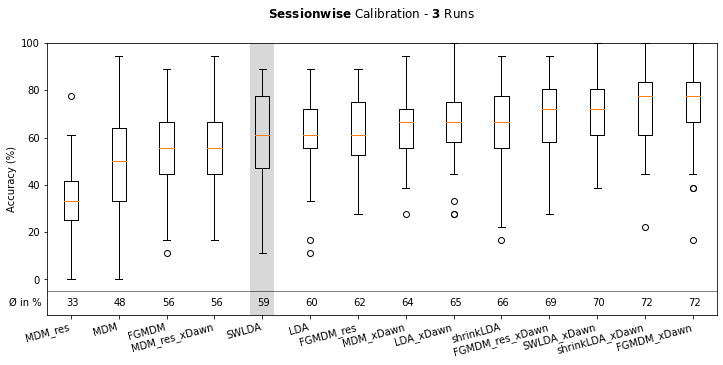

In [122]:
boxplot_accuracy(sess3,r"Sessionwise Calibration - 3 Runs",r"$\bf{Sessionwise}$ Calibration - $\bf{3}$ Runs")

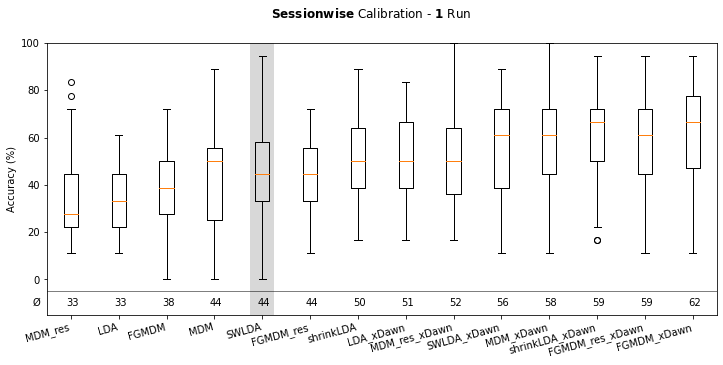

In [113]:
boxplot_accuracy(sess1,"Sessionwise Calibration - 1 Run",r"$\bf{Sessionwise}$ Calibration - $\bf{1}$ Run")

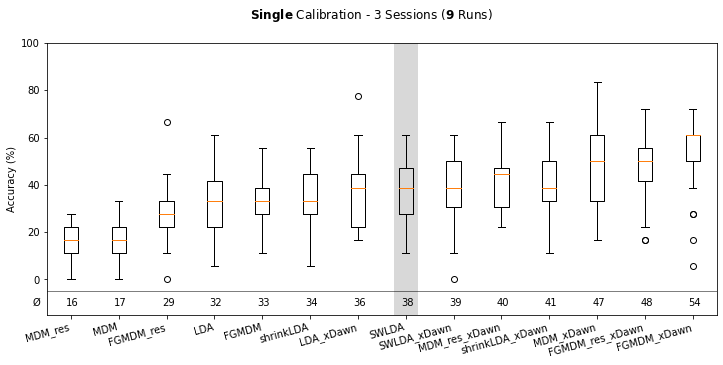

In [114]:
boxplot_accuracy(single3,r"Single Calibration - 3 Sessions (9 Runs)",r"$\bf{Single}$ Calibration - 3 Sessions ($\bf{9}$ Runs)")

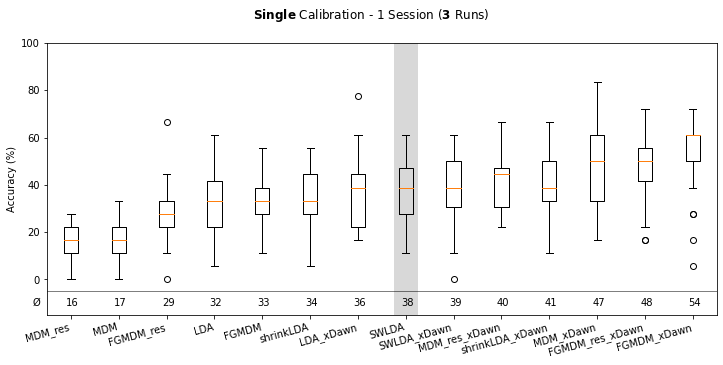

In [115]:
boxplot_accuracy(single1,r"Single Calibration - 1 Session (3 Runs)",r"$\bf{Single}$ Calibration - 1 Session ($\bf{3}$ Runs)")

# Amplitudes

In [27]:
amp = pd.read_csv(r"C:\Users\map92fg\Documents\Software\P300_Classification\created_data\average_amplitudes_350_600_with_dates.csv")
t = amp.loc[(amp.Condition=="Target")&(amp.Electrode=="Cz")]
nt= amp.loc[(amp.Condition=="nonTarget")&(amp.Electrode=="Cz")]

In [28]:
t_mean = t.groupby('Dates').mean()
t_mean = t_mean.set_index(pd.to_datetime(t_mean.index,dayfirst=True),drop=True)
t_mean = t_mean.sort_index()
nt_mean = nt.groupby('Dates').mean()
nt_mean = nt_mean.set_index(pd.to_datetime(nt_mean.index,dayfirst=True),drop=True)
nt_mean = nt_mean.sort_index()

In [29]:
t_std = t.groupby('Dates').std()
t_std = t_std.set_index(pd.to_datetime(t_std.index,dayfirst=True),drop=True)
t_std = t_std.sort_index()
nt_std = nt.groupby('Dates').std()
nt_std = nt_std.set_index(pd.to_datetime(nt_std.index,dayfirst=True),drop=True)
nt_std = nt_std.sort_index()

In [30]:
t_ci = t_std["Mean Amplitude"]*1.96/np.sqrt(6)
nt_ci = nt_std["Mean Amplitude"]*1.96/np.sqrt(6)
t_ci = [(t_mean["Mean Amplitude"]-t_ci).to_list(), (t_mean["Mean Amplitude"]+t_ci).to_list()]
nt_ci = [(nt_mean["Mean Amplitude"]-nt_ci).to_list(), (nt_mean["Mean Amplitude"]+nt_ci).to_list()]

In [354]:
[(t_mean["Mean Amplitude"]-t_ci).to_list(), (t_mean["Mean Amplitude"]+t_ci).to_list()]
[(nt_mean["Mean Amplitude"]-nt_ci).to_list(), (nt_mean["Mean Amplitude"]+nt_ci).to_list()]

[[-0.7105314683453487,
  0.9053744847598102,
  0.7874218432186137,
  -0.42000099550864145,
  0.5110922952468733,
  1.1649889024940467,
  -0.7033696527609828,
  1.272168716324589,
  2.379509901776731,
  2.022208175731102,
  0.8766293320015426,
  0.848418922183546,
  1.0253166692680937,
  0.25589364726201436,
  0.4653473746773571,
  -1.0319614365922782,
  0.7567117610247309],
 [5.03064312255637,
  4.035813359833413,
  3.0446372483337423,
  2.8247666664674425,
  3.1350339330902237,
  4.475791649680516,
  2.636669937590968,
  3.267124504398131,
  3.431088859876848,
  2.8989197271664655,
  2.79983379365197,
  2.278111508140746,
  3.667834441429749,
  3.4433385912417735,
  3.123037087355678,
  1.6008637409807345,
  2.1508897514696996]]

0.17301501415860188


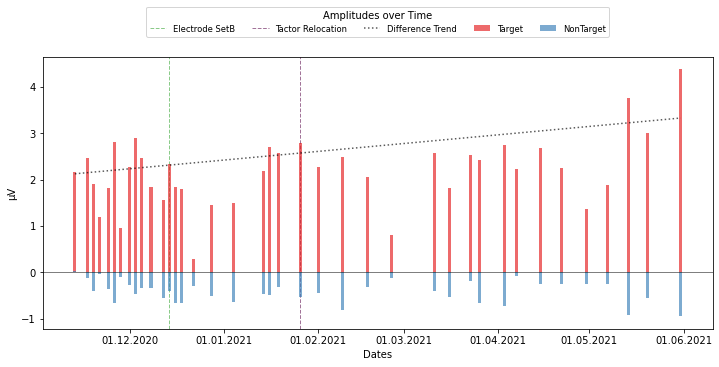

In [96]:
import matplotlib.dates as mdates
def plot_timeline(tar_df, ntar_df,electrode,title):
    col_list= ["#377eb8","#e41a1c","#4daf4a","#702963"]
    lr = LinearRegression()

    x = tar_df.index.map(dt.datetime.toordinal).to_numpy()
    x = x.reshape(-1,1)

    fig, ax = plt.subplots(figsize = (12,5))
    y = tar_df["Mean Amplitude"].to_numpy()-ntar_df["Mean Amplitude"].to_numpy()
    y.reshape(-1,1)
    lr.fit(x,y)
    pred = lr.predict(x)
    ##ax.text(3, 8, 'R² = '+ str(round(lr.score(x,y),3), style='italic',bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 10})
    print(lr.score(x,y))
    ax.axvline(x=tar_df.index.values[12],alpha=0.65,zorder=0,c=col_list[2],ls="--",lw=1) # electrode set b    
    ax.axvline(x=tar_df.index.values[21],alpha=0.65,zorder=0,c=col_list[3], ls="--",lw=1)
    tar = ax.bar(tar_df.index,tar_df["Mean Amplitude"], width=1,color=col_list[1],alpha=0.65)
    ntar = ax.bar(tar_df.index,ntar_df["Mean Amplitude"], width=1,color=col_list[0],alpha=0.65)
    trend = ax.plot(tar_df.index,pred,c="k",ls=":",lw=1.5,alpha=0.65)
    lgd =ax.legend(["Electrode SetB","Tactor Relocation","Difference Trend", "Target", "NonTarget"], ncol=5, title=title,loc='center', bbox_to_anchor=(0.5, 1.13),fontsize='small', fancybox=True)
    ax.axhline(y=0,c='k',lw=0.5)
    ax.set_ylabel("µV")
    #specify x ticks
    #ax.set_xticks(pd.DatetimeIndex(["10.11.2020","1.12.2020","1.1.2021"],dayfirst=True))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%d.%m.%Y"))
    ax.xaxis.set_minor_formatter(mdates.DateFormatter("%Y-%m"))
    ax.set_xlabel("Dates")
    #fig.suptitle(title)
    fig.tight_layout
    plt.savefig(r"C:\Users\map92fg\Documents\Software\P300_Classification\data_thesis\Timeline.svg",bbox_inches="tight",pad_inches=0.2,format="svg")
plot_timeline(t_mean,nt_mean,"Cz","Amplitudes over Time")

In [32]:
nt.describe()

,Session,Tactilo,Mean Amplitude
count,234.000000,234.000000,234.000000
mean,27.589744,3.500000,-0.417037
std,14.302168,1.711486,0.709138
min,1.000000,1.000000,-2.356149
25%,15.000000,2.000000,-0.915173
50%,29.000000,3.500000,-0.466613
75%,40.000000,5.000000,0.067242
max,49.000000,6.000000,2.178747


In [33]:
t.describe()

,Session,Tactilo,Mean Amplitude
count,234.000000,234.000000,234.000000
mean,27.589744,3.500000,2.184518
std,14.302168,1.711486,1.547806
min,1.000000,1.000000,-2.687324
25%,15.000000,2.000000,1.265328
50%,29.000000,3.500000,2.169594
75%,40.000000,5.000000,3.108613
max,49.000000,6.000000,6.655833


# ROC curves

In [132]:
all_roc = pd.read_csv(r"G:\Andere Computer\Work\Software\P300_Classification\created_data\Classifier_Results\roc.csv")

In [102]:
for i in range(40):
    print(roc.loc[(roc.Classifier=="LDA_xDawn")&(roc.Session==i)].shape)

AttributeError: 'DataFrame' object has no attribute 'Classifier'

AttributeError: 'tuple' object has no attribute 'FPR'

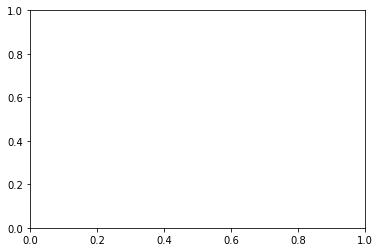

In [88]:
fig, ax = plt.subplots()
ax.plot(swlda_xDawn.FPR,swlda_xDawn.TPR)

ValueError: Cannot cut empty array

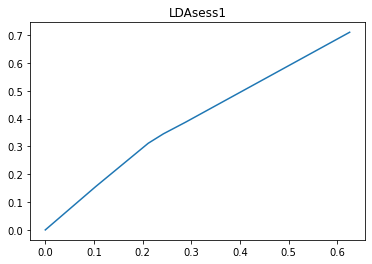

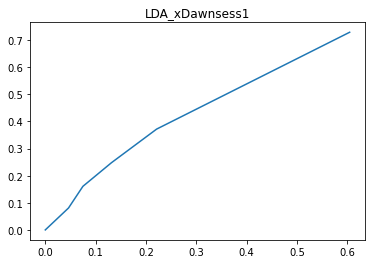

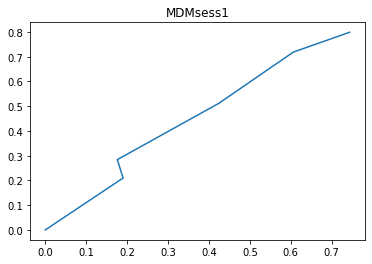

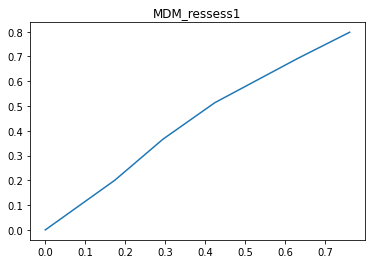

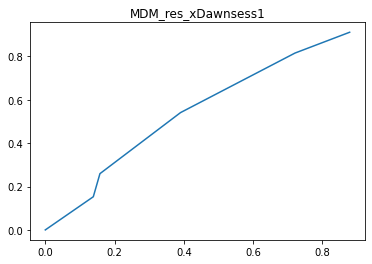

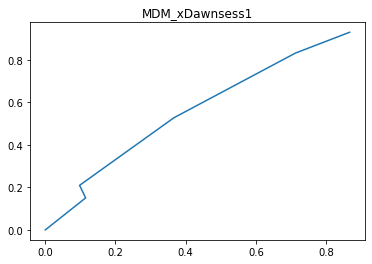

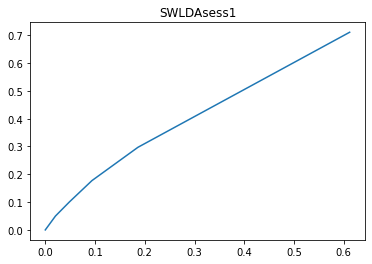

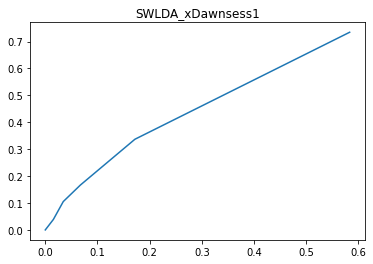

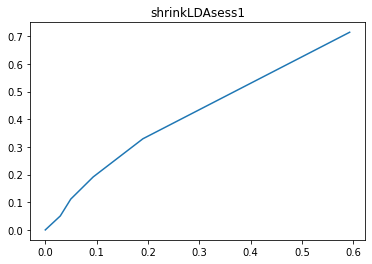

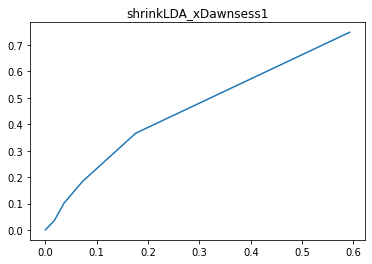

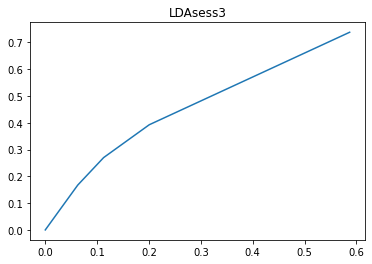

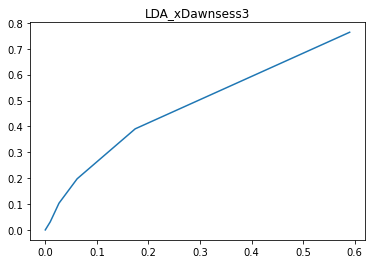

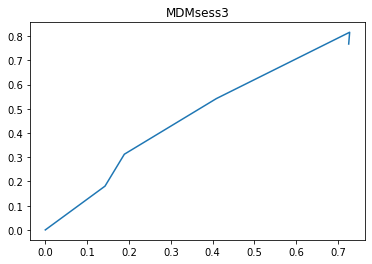

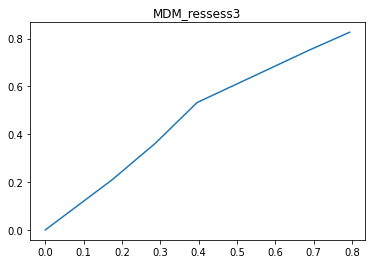

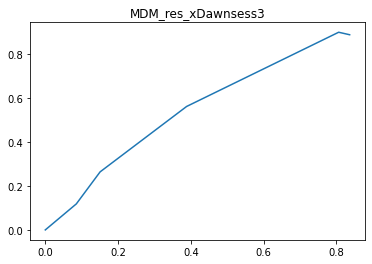

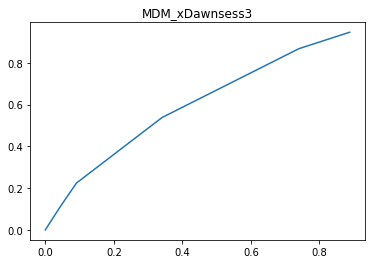

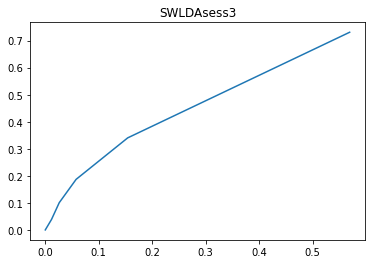

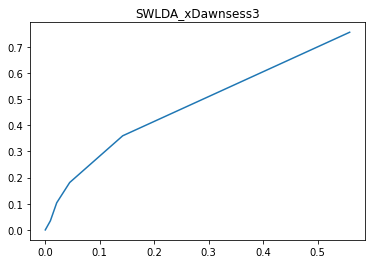

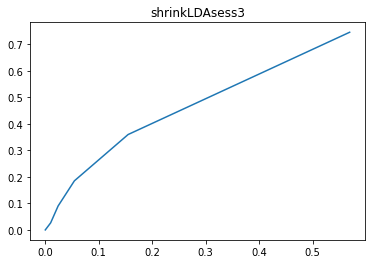

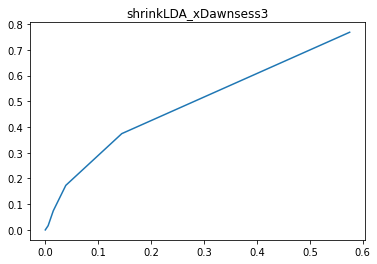

In [129]:
for condition in np.unique(all_roc.Condition):
    for classifier in np.unique(all_roc.Classifier):
        roc = all_roc.loc[(all_roc.Classifier==classifier) & (all_roc.Condition==condition)]
        roc["Treshold_bin"] = pd.cut(roc.Treshold,10)
        roc = roc.groupby("Treshold_bin").mean().dropna()
        fig, ax = plt.subplots()
        ax.plot(roc.FPR,roc.TPR)
        
        title = classifier + condition
        ax.set_title(title)

In [133]:
np.unique(all_roc.Condition)

array(['sess1', 'sess3', 'single3_A'], dtype=object)

In [125]:
roc = all_roc.loc[(all_roc.Classifier=="MDM") & (all_roc.Condition=="sess3")]

In [128]:
roc.describe()

,Session,Treshold,FPR,TPR
count,18260.000000,1.826000e+04,18260.000000,18260.000000
mean,27.414677,5.206089e-01,0.408453,0.523007
std,14.353917,1.994169e-01,0.288303,0.289000
min,1.000000,1.040156e-07,0.000000,0.000000
25%,15.000000,4.988733e-01,0.152778,0.277778
50%,29.000000,4.999859e-01,0.361111,0.534722
75%,40.000000,5.315405e-01,0.645833,0.770833
max,49.000000,2.000000e+00,1.000000,1.000000
